In [1]:
import json
import ufl
import dolfin as dl

#sys.path.append(os.environ.get('HIPPYLIB_PATH', "../../"))
import hippylib as hp
#sys.path.append(os.environ.get('HIPPYFLOW_PATH',"../../"))
import hippyflow as hf

from helpers import *
from generate_samples import *
from train_nn import *



/home/jt925938/anaconda3/envs/gempy_dino/lib/python3.10/site-packages/dolfin/jit/jit.py:121: RuntimeWarning: mpi4py.MPI.Session size changed, may indicate binary incompatibility. Expected 32 from C header, got 40 from PyObject
  def compile_class(cpp_data, mpi_comm=MPI.comm_world):
/home/jt925938/anaconda3/envs/gempy_dino/lib/python3.10/site-packages/dolfin/jit/jit.py:46: RuntimeWarning: mpi4py.MPI.Session size changed, may indicate binary incompatibility. Expected 32 from C header, got 40 from PyObject
  if MPI.size(mpi_comm) == 1:


Setting Backend To: AvailableBackends.numpy


/home/jt925938/anaconda3/envs/gempy_dino/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Setup Mesh, and Functional spaces and PDE

In [2]:
nx =31; ny = 31
nodes = (nx+1)*(ny+1)
mesh = dl.RectangleMesh(dl.Point(0.0, 0.0), dl.Point(1.0, 1.0), nx, ny)
Vh_STATE = dl.FunctionSpace(mesh, "CG", 2)
Vh_PARAMETER = dl.FunctionSpace(mesh, "CG", 1)
Vh = [Vh_STATE, Vh_PARAMETER, Vh_STATE]

d2v = dl.dof_to_vertex_map(Vh[hp.PARAMETER])
v2d = dl.vertex_to_dof_map(Vh[hp.PARAMETER])


def u_boundary(x, on_boundary):
    return on_boundary and ( x[1] < dl.DOLFIN_EPS or x[1] > 1.0 - dl.DOLFIN_EPS)

u_bdr = dl.Expression("x[1]", degree=1)
u_bdr0 = dl.Constant(0.0)
bc = dl.DirichletBC(Vh[hp.STATE], u_bdr, u_boundary)
bc0 = dl.DirichletBC(Vh[hp.STATE], u_bdr0, u_boundary)

f = dl.Constant(0.0)
#f = dl.Expression("sin(2*pi*x[0]) * exp(x[1]+ x[0])", degree=5)

def pde_varf(u,m,p):
    return m*ufl.inner(ufl.grad(u), ufl.grad(p))*ufl.dx - f*p*ufl.dx
    

pde = hp.PDEVariationalProblem(Vh, pde_varf, bc, bc0, is_fwd_linear=True)


In [3]:
u_trial = dl.TrialFunction(Vh[hp.STATE])
u_test = dl.TestFunction(Vh[hp.STATE])

M_U = dl.assemble(dl.inner(u_trial,u_test)*dl.dx)

I_U = hf.StateSpaceIdentityOperator(M_U)
#observable = hf.LinearStateObservable(pde,M_U)
observable = hf.LinearStateObservable(pde,I_U)

Jm = hf.ObservableJacobian(observable)

m_trial = dl.TrialFunction(Vh[hp.PARAMETER])
m_test = dl.TestFunction(Vh[hp.PARAMETER])

M_M = dl.assemble(dl.inner(m_trial,m_test)*dl.dx)

## Setup the Gempy

Setting Backend To: AvailableBackends.numpy


/home/jt925938/anaconda3/envs/gempy_dino/lib/python3.10/site-packages/gempy/core/data/geo_model.py:164: UserWarning: You are using refinement and passing a regular grid. The resolution of the regular grid will be overwritten
  warnings.warn(


Active grids: ['custom']
Setting Backend To: AvailableBackends.numpy
Setting Backend To: AvailableBackends.numpy


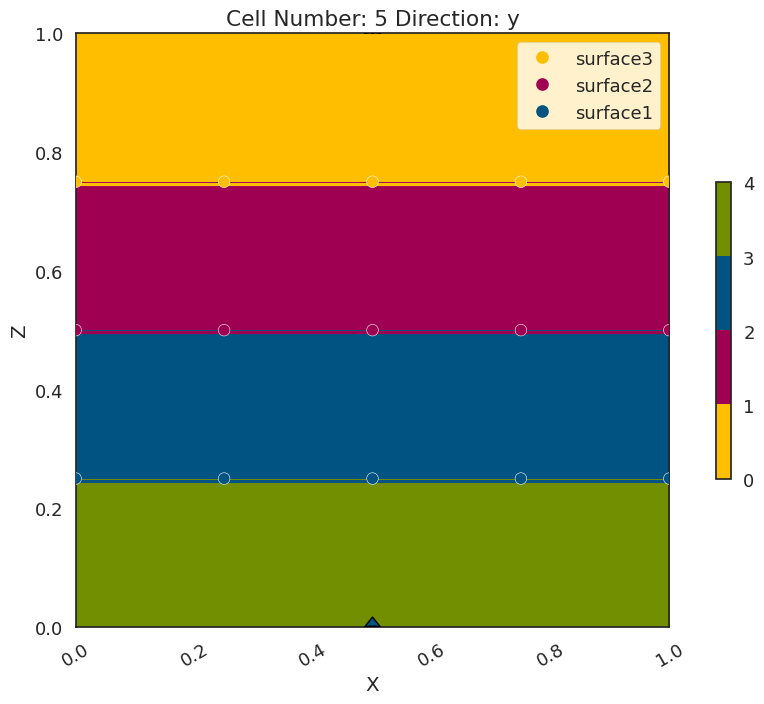

In [4]:
m_initial= create_true_data(mesh=mesh, nodes=nodes, filename=None)

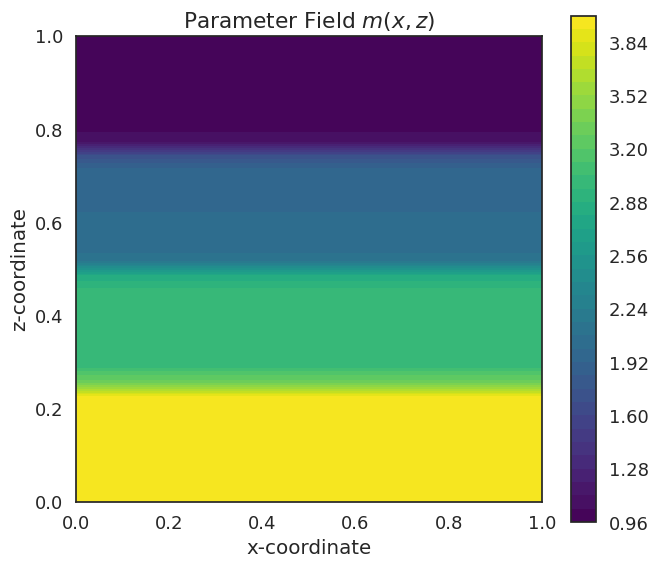

In [5]:
m = dl.Function(Vh[hp.PARAMETER])
m.vector().set_local(m_initial[d2v])
# plt.axis("off")
col = dl.plot(m,cmap="viridis" )
fig = plt.gcf()
fig.colorbar(col) 
# Add axis labels and title
plt.xlabel("x-coordinate")
plt.ylabel("z-coordinate")
plt.title("Parameter Field $m(x,z)$")

plt.tight_layout()
fig.set_size_inches(6, 6)

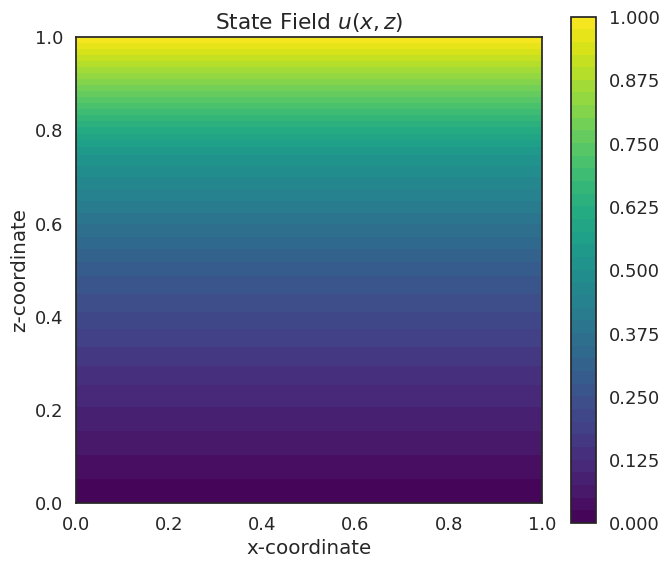

In [6]:
u = dl.Function(Vh[hp.STATE])
uadj = dl.Function(Vh[hp.ADJOINT])
x = [u.vector(),m.vector(),uadj.vector()]
pde.solveFwd(x[hp.STATE], x)
# Get the data
u_true = x[hp.STATE].get_local()
# plot u_true
u.vector().set_local(u_true)
# plt.axis("off")
col = dl.plot(u,cmap="viridis" )
fig = plt.gcf()
fig.colorbar(col) 
# Add axis labels and title
plt.xlabel("x-coordinate")
plt.ylabel("z-coordinate")
plt.title("State Field $u(x,z)$")

plt.tight_layout()
fig.set_size_inches(6, 6)


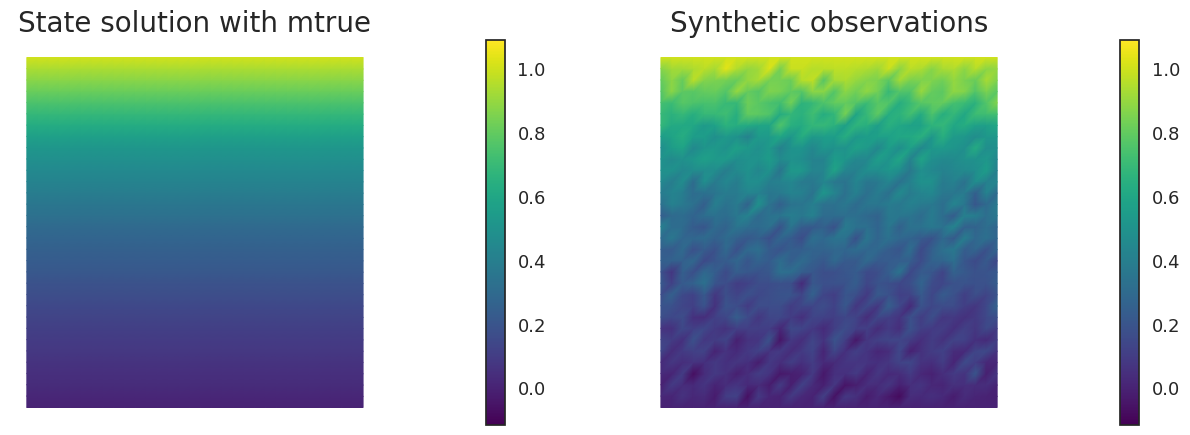

In [7]:
# noise level
noise_level = 0.05


ud = dl.Function(Vh[hp.STATE])
ud.assign(u)

# perturb state solution and create synthetic measurements ud
# ud = u + ||u||/SNR * random.normal
MAX = ud.vector().norm("linf")

# Create noise vector and insert the numpy array
noise = dl.Vector()
M_U.init_vector(noise, 1)
hp.parRandom.normal(noise_level * MAX, noise)

bc0.apply(noise)

ud.vector().axpy(1., noise)

# plot
hp.nb.multi1_plot([u, ud], ["State solution with mtrue", "Synthetic observations"])
# Add axis labels and title

plt.show()


In [8]:

# data = generate_input_output_gempy_data_(mesh=mesh, number_samples=50,nodes=nodes, filename=None)
# c,m_data, dmdc_data = np.array(data["input"]),np.array(data["Gempy_output"]), np.array(data["Jacobian_Gempy"])
# c.shape, type(c), m_data.shape, type(m_data),dmdc_data.shape, type(dmdc_data)

In [9]:

direcoty_path="../Results/Nodes_"+str((nx+1)*(ny+1))

# Path to your JSON file
filename = direcoty_path+ "/data_9_parameter.json"
# Open and load the file
with open(filename, 'r') as file:
    data = json.load(file)

c, m_data, dmdc_data = np.array(data["input"]),np.array(data["Gempy_output"]), np.array(data["Jacobian_Gempy"])
n=1000 # Number of samples we need
c=c[:n]
m_data = m_data[:n]
dmdc_data = dmdc_data[:n]
c.shape, type(c), m_data.shape, type(m_data),dmdc_data.shape, type(dmdc_data)

((1000, 9),
 numpy.ndarray,
 (1000, 1024),
 numpy.ndarray,
 (1000, 1024, 9),
 numpy.ndarray)

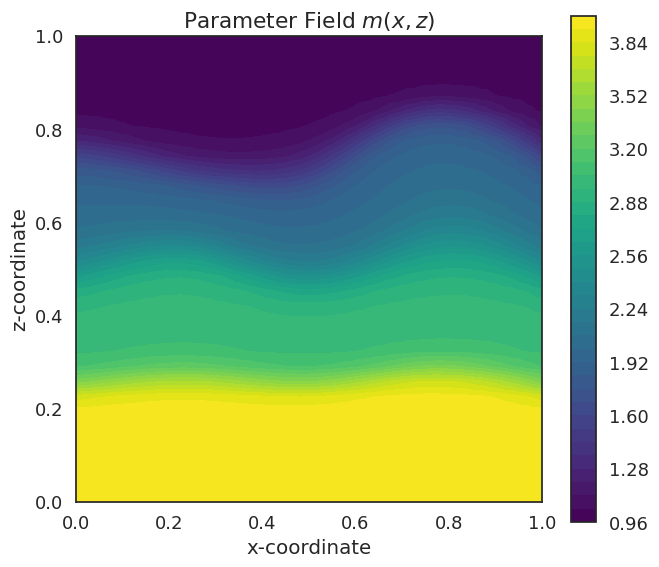

In [10]:
m = dl.Function(Vh[hp.PARAMETER])
m_nodes_hat = dl.Function(Vh[hp.PARAMETER])
m_hat = dl.Function(Vh[hp.PARAMETER])
m.vector().set_local(m_data[0,:][d2v])
A= m.vector().get_local()
#plt.axis("off")
col = dl.plot(m,cmap="viridis" )
fig = plt.gcf()
fig.colorbar(col) 
# Add axis labels and title
plt.xlabel("x-coordinate")
plt.ylabel("z-coordinate")
plt.title("Parameter Field $m(x,z)$")

plt.tight_layout()
fig.set_size_inches(6, 6)
# plt.savefig("debug_output.png", dpi=300)

In [11]:
# plt.imshow(A[v2d].reshape((nx+1,ny+1)),cmap="viridis" ,origin='lower',extent=[0, 1, 0, 1],interpolation='bilinear')
# # Set figure size to 3x3 inches
# plt.gcf().set_size_inches(3, 3)

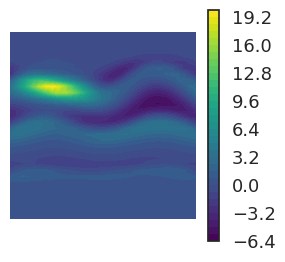

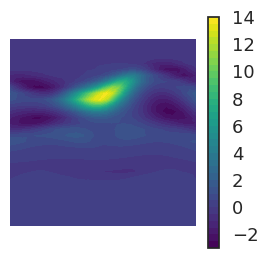

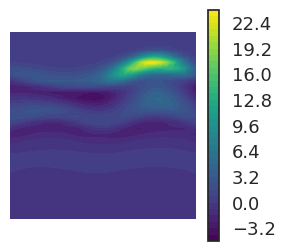

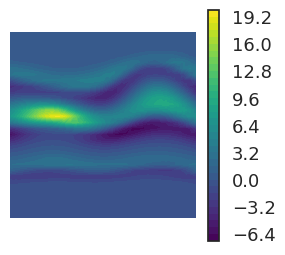

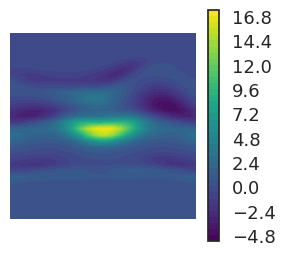

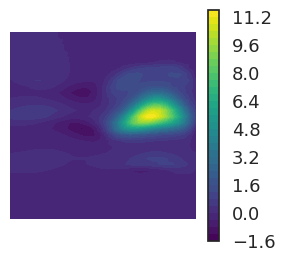

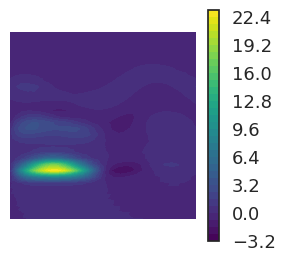

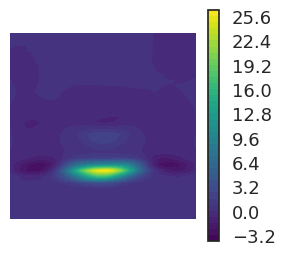

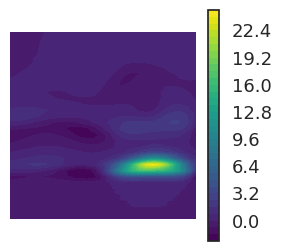

In [12]:
for i in range(c.shape[1]):
    m_nodes_hat.vector().set_local(dmdc_data[0,:,i][d2v])
    plt.axis("off")
    col= dl.plot(m_nodes_hat, cmap="viridis")
    fig = plt.gcf()
    fig.colorbar(col) 
    fig.set_size_inches(3, 3)
    plt.show()

## Generate samples of the state.


NOTE I AM USING A SIMPLE MPI RANK PROCESS SO THE ARRAY OPERATION `.get_local()` MAY NEED TO BE MODIFIED IN AN MPI PARALLEL CONTEXT. HOWEVER FOR PROBLEMS THAT ARE THIS SMALL THERE IS NO JUSTIFICATION FOR MPI PARALLELISM FOR THE MESH

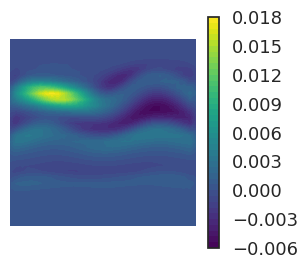

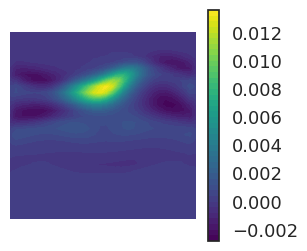

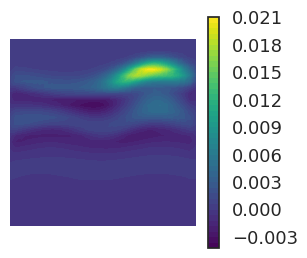

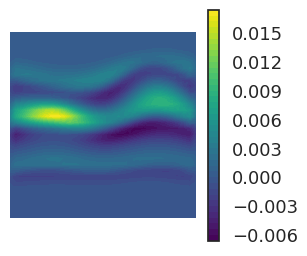

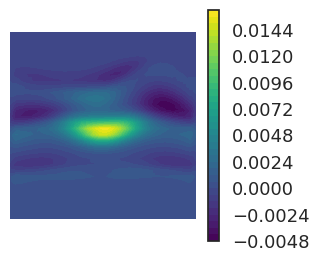

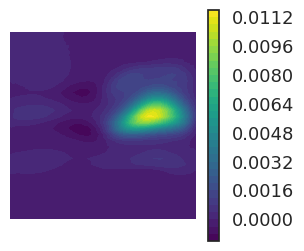

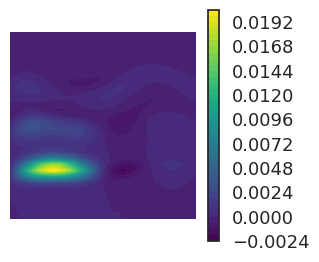

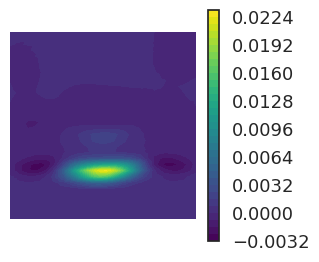

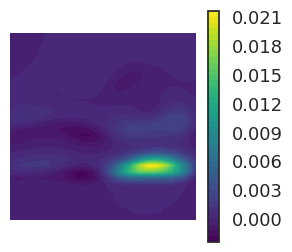

In [13]:
for i in range(c.shape[1]):
    m_nodes_hat.vector().set_local(dmdc_data[0,:,i][d2v])
    M_M.mult(m_nodes_hat.vector(), m_hat.vector())
    plt.axis("off")
    col= dl.plot(m_hat, cmap="viridis")
    #dl.plot(m_nodes_hat)
    fig = plt.gcf()
    fig.colorbar(col) 
    fig.set_size_inches(3, 3)
    plt.show()

In [14]:
nsamples = c.shape[0]

m = dl.Function(Vh[hp.PARAMETER])

u = dl.Function(Vh[hp.STATE])
uadj = dl.Function(Vh[hp.ADJOINT])

dU = u.vector().get_local().shape[0]

dC = c.shape[1]

# once you have modified the means of c->m(c) comment this
uhat = dl.Function(Vh[hp.STATE])
m_nodes_hat = dl.Function(Vh[hp.PARAMETER])
m_hat = dl.Function(Vh[hp.PARAMETER])
u_data = np.zeros((nsamples,dU))
J_data = np.zeros((nsamples, dU, dC))

plotting = False
for sample_index in range(nsamples):
    # Do something here to modify the coefficients
   
    m_values = m_data[sample_index,:]
    m.vector().set_local(m_values[d2v]) #uncomment this
    # m.vector().set_local(m_values[d2v] +0.1*np.random.randn(m_values.shape[0])) #comment this
    if plotting:
        #plt.axis("off")
        dl.plot(m,cmap="viridis")
        fig = plt.gcf()
        fig.set_size_inches(1, 1)
        plt.show()
        # Plot with color

    
    x = [u.vector(),m.vector(),uadj.vector()]
    pde.solveFwd(x[hp.STATE], x)
    
    Jm.observable.setLinearizationPoint(x)
    
    
    # Get the data
    u_data[sample_index,:] = x[hp.STATE].get_local()
    # Calculate the Jacobian
    for component in range(dC):
        m_nodes_hat.vector().set_local(dmdc_data[sample_index,:,component][d2v]) 
        Jm.mult(m_nodes_hat.vector(),uhat.vector()) 
        # Multiply dmdc by Mass matrix.
        # M_M.mult(m_nodes_hat.vector(), m_hat.vector()) 
        # Jm.mult(m_hat.vector(),uhat.vector()) 
        J_data[sample_index,:,component] = uhat.vector().get_local()
    
u_data.shape, J_data.shape

((1000, 3969), (1000, 3969, 9))

## POD

In [15]:
# u_trial = dl.TrialFunction(Vh[hp.STATE])
# u_test = dl.TestFunction(Vh[hp.STATE])

# M_U = dl.assemble(dl.inner(u_trial,u_test)*dl.dx)

POD = hf.PODProjectorFromData(Vh,M_output = M_U)

mean_shifting = True

# Change this later on to be chosen appropriately.
u_rank = len(u_data)
print(u_rank)
d, phi, Mphi, u_shift  = POD.construct_subspace(u_data, u_rank, shifted=mean_shifting, method='hep', verify=True)
phi.shape, Mphi.shape

1000
Using HEP
NOTE: number of data points 1000 is comparable to vector dimension 3969.
Recommend using method==ghep
Preprocessing took 0.113 seconds
Eigenvalue solve took 0.13 seconds
Postprocessing took 2.27 seconds
Basis Orthogonality error: 5.220234359046497
Basis-Projector Orthogonality error: 5.220234359046497
Mean reconstruction error: 1.358e-07
Max reconstruction error: 5.002e-07


((3969, 1000), (3969, 1000))

/tmp/jt925938/login23-g-1_32092/ipykernel_222915/1568989377.py:1: RuntimeWarning: invalid value encountered in log10
  plt.plot(np.arange(d.shape[0]), np.log10(d))


Text(0.5, 1.0, 'Eigenvalue distribution')

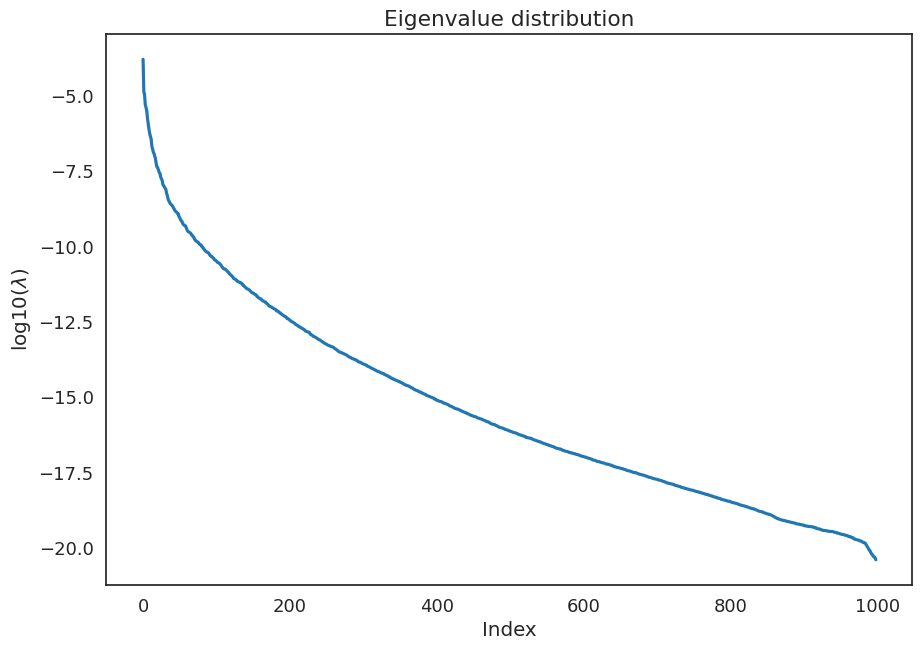

In [16]:
plt.plot(np.arange(d.shape[0]), np.log10(d))
plt.xlabel("Index")
plt.ylabel("log10($\lambda$)")
plt.title("Eigenvalue distribution")

In [17]:
r = np.sum(d>=1e-7)
# r =20
r

16

In [18]:
Mphi.shape, phi.shape, u_shift.shape

((3969, 1000), (3969, 1000), (3969,))

In [19]:

Mphi = Mphi[:, :r]
phi = phi[:,:r]
Mphi.shape, phi.shape

((3969, 16), (3969, 16))

In [ ]:
# Save to file
np.save('./saved_model/Mphi.npy', Mphi)
np.save('./saved_model/phi.npy', phi)
np.save('./saved_model/u_shift.npy', u_shift)

In [20]:
## Compare reconstructions in POD basis

################################################################################
True state


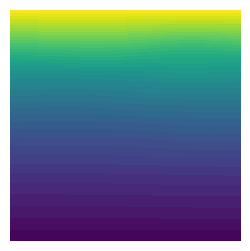

################################################################################
POD projected state


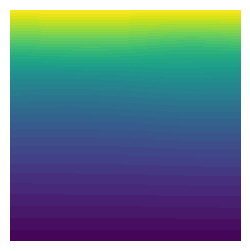

################################################################################
As you can see, this problem is trivial, as only ten modes basically perfectly reconstruct the trivial output function


In [50]:
print(80*'#')
print('True state')
u.vector().set_local(u_data[0])
plt.axis("off")
dl.plot(u, cmap="viridis")
fig = plt.gcf()
fig.set_size_inches(3, 3)
plt.show()

print(80*'#')
print('POD projected state')
u.vector().set_local(phi@Mphi.T@(u_data[0] - u_shift) + u_shift)
plt.axis("off")
dl.plot(u,cmap="viridis")
fig = plt.gcf()
fig.set_size_inches(3, 3)
plt.show()

print(80*'#')
print('As you can see, this problem is trivial, as only ten modes basically perfectly reconstruct the trivial output function')

## (Linear) encoders and decoders.

Please consult our papers for a more in-depth discussion. E.g., [section 2.4 in this work](https://arxiv.org/abs/2411.12726)

We can expand a function on an orthonormal basis as

$$ u(x) = \sum_{i=1}^\infty \langle u(x),\phi_i(x)\rangle_\mathcal{U} \phi_i(x)$$

and the truncated representation

$$ u(x) = \sum_{i=1}^r \langle u(x),\phi_i(x)\rangle_\mathcal{U} \phi_i(x)$$

The encoder is the mapping from the data $u(x)$ to its truncated coefficient expansion $\mathcal{E}_r u \in \mathbb{R}^{r}$

$$ \mathcal{E}_r u = \left[\langle u,\phi_i\rangle_\mathcal{U}\right]_{i=1}^r \in \mathbb{R}^{r}$$

The decoder maps this data back to the function space (e.g., the basis expansion operation), given $\alpha \in \mathbb{R}^r$ we have

$$ \mathcal{D}_r \alpha  = \sum_{i=1}^r \alpha_i \phi_i$$

The encoder has the effect of the inner product $\langle \cdot,\cdot\rangle_\mathcal{U}$, e.g., the mass matrix in finite elements, each column of it is $\langle \cdot, \phi\rangle_\mathcal{U}$, so we call it `Mphi` $\in \mathbb{R}^{d_u \times r}$. Likewise we call the decoder `\phi` since its columns are just the basis vectors

### Encoding u data

The mapping to the coefficients of u is $u_r = \mathcal{E}_r u$. In numpy this is `ur_data = Mphi.T@u_data`

### Decoding the u data

We decode with the basis: $\mathcal{D}_r u_r$. In numpy this is `phi@ur_data`

### Encoding and decoding the derivatives.

The derivative of the map is 

$$ Du(c) \in \mathcal{L}(\mathbb{R}^{d_c},\mathcal{U}) $$

that is, the space of linear operators from $\mathbb{R}^{d_c}$ into $\mathcal{U}$. We want to remove the high-dimensionality associated with $\mathcal{U}$

This is done with the encoder operator:

$$\mathcal{E}_r Du(c) \in \mathbb{R}^{r\times d_c}$$

In [51]:
# Encode the u_data

ur = np.einsum('ur,du->dr',Mphi,u_data)

# Encoder the Du_data

# dc = 2
# Du_data = np.random.randn(nsamples,dU,dc)
# Dur_data = np.einsum('ur,duc->drc',Mphi,Du_data)

## Training data

The training data then is inputs (`c_data` \in $\mathbb{R}^{nsamples\times dc}$) and outputs (`ur_data`, `Dur_data`)


## To figure out in the $Du(c)$ calculations

The derivative I believe should have the mass matrix for $\mathcal{M}$ space in it:

$$ Du(c) = D_m(u(m(c)) \frac{dm}{dc} = -\left[\frac{\partial R}{\partial u}\right]^{-1}\frac{\partial R}{\partial m} \frac{dm}{dc}$$

In the other notebook we are evaluating the mapping from $c\mapsto m_\text{node}$, the nodal representation of $m$, but not the function. The mapping to the function requires the mass matrix

The torch gempy code will give you
$$ \frac{dm_\text{node}}{dc}$$

and we need in the end
$$ \frac{dm}{dc} = M_\mathcal{M} \frac{dm_\text{node}}{dc}$$

In [52]:
# Calculating the mass matrix for $\mathcal{M}$


In [53]:
# m_trial = dl.TrialFunction(Vh[hp.PARAMETER])
# m_test = dl.TestFunction(Vh[hp.PARAMETER])

# M_M = dl.assemble(dl.inner(m_trial,m_test)*dl.dx)

## Final form of the pre-reduced Jacobian

$$ Du(c) = -\left[\frac{\partial R}{\partial u}\right]^{-1}\frac{\partial R}{\partial m} M_\mathcal{M}\frac{dm_\text{node}}{dc}$$

Where 

$$ \frac{dm_\text{node}}{dc} \in \mathbb{R}^{d_\text{node}\times dc}$$

is the nodal Jacobian you will get as the output from the gempy torch automatic differntiation

## DOF ORDERING FOR m

You will also need to check the correct degree of freedom mapping for $m$

It will likely be something like the code we had: `m_values[d2v]`

So the output of your torch AD for dm_node/dc will need to have each column reordered using the d2v re-ordering.

When in doubt, plot everything. Do you see that I am constantly plotting to make sure that I am dealing with the right thing? If you get the vertex to dof map wrong you will be able to see it immediately via plotting columns of the Jacobian.

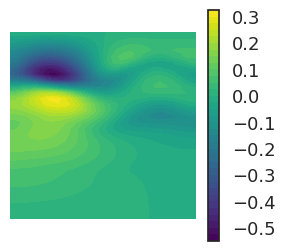

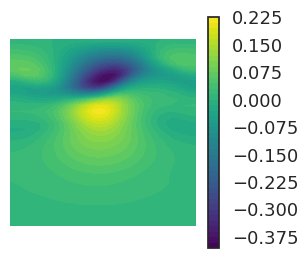

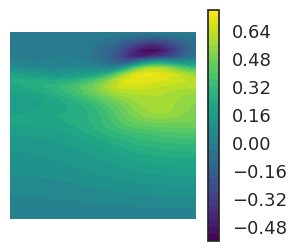

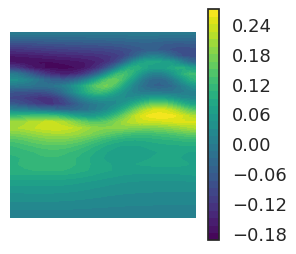

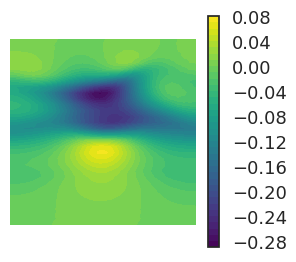

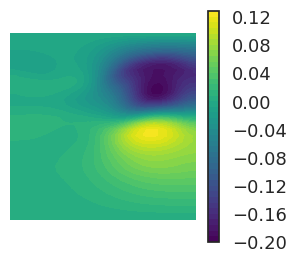

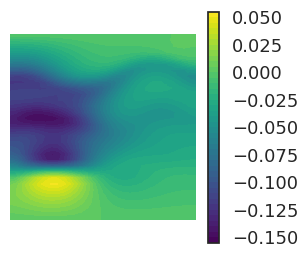

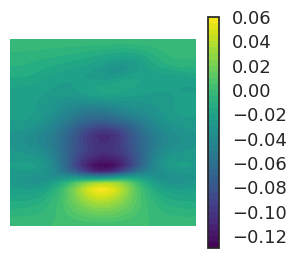

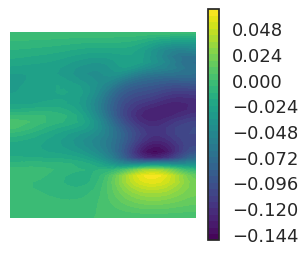

In [54]:
for i in range(c.shape[1]):
    u_hat = dl.Function(Vh[hp.STATE])
    u_hat.vector().set_local(J_data[0,:,i])
    plt.axis("off")
    col=dl.plot(u_hat,cmap="viridis")
    fig = plt.gcf()
    fig.colorbar(col) 
    fig.set_size_inches(3, 3)
    plt.show()

In [55]:
Dur = np.einsum('ur,duc->drc',Mphi,J_data)
ur.shape, Dur.shape

((1000, 16), (1000, 16, 9))

In [56]:
layer_sizes=[c.shape[1],c.shape[1],r,r]
n_samples_data = c.shape[0]
epoch = 100
train_network(Gempy_Inputs=c[:n_samples_data], PDE_outputs=ur[:n_samples_data], Jacobian=Dur[:n_samples_data], layer_sizes=layer_sizes, num_epochs=epoch)

Train size: 600,Valid size: 200,  Test size: 200
Epoch [0/100], Train Loss: 0.4504, Val Loss: 1.7148
Epoch [10/100], Train Loss: 0.0003, Val Loss: 0.0019
Epoch [20/100], Train Loss: 0.0002, Val Loss: 0.0018
Epoch [30/100], Train Loss: 0.0002, Val Loss: 0.0018
Epoch [40/100], Train Loss: 0.0002, Val Loss: 0.0017
Epoch [50/100], Train Loss: 0.0002, Val Loss: 0.0017
Epoch [60/100], Train Loss: 0.0002, Val Loss: 0.0017
Epoch [70/100], Train Loss: 0.0002, Val Loss: 0.0017
Epoch [80/100], Train Loss: 0.0002, Val Loss: 0.0016
Epoch [90/100], Train Loss: 0.0002, Val Loss: 0.0016
Epoch [99/100], Train Loss: 0.0002, Val Loss: 0.0016
L2 accuracy without Jacobian:  tensor(0.9644, device='cuda:0', grad_fn=<RsubBackward1>)


In [57]:
train_network(network_type="full", Gempy_Inputs=c[:n_samples_data], PDE_outputs=ur[:n_samples_data], Jacobian=Dur[:n_samples_data], layer_sizes=layer_sizes, num_epochs=epoch)

Train size: 600,Valid size: 200,  Test size: 200
Epoch [0/100], Train Loss: 0.5429, Val Loss: 3.0529, L2 Loss: 0.2301, F2 Loss: 0.3128
Epoch [10/100], Train Loss: 0.2507, Val Loss: 1.8815, L2 Loss: 0.0002, F2 Loss: 0.2505
Epoch [20/100], Train Loss: 0.2419, Val Loss: 1.8230, L2 Loss: 0.0001, F2 Loss: 0.2418
Epoch [30/100], Train Loss: 0.2403, Val Loss: 1.7854, L2 Loss: 0.0001, F2 Loss: 0.2402
Epoch [40/100], Train Loss: 0.2051, Val Loss: 1.5228, L2 Loss: 0.0001, F2 Loss: 0.2050
Epoch [50/100], Train Loss: 0.1998, Val Loss: 1.4875, L2 Loss: 0.0001, F2 Loss: 0.1998
Epoch [60/100], Train Loss: 0.1990, Val Loss: 1.4961, L2 Loss: 0.0001, F2 Loss: 0.1989
Epoch [70/100], Train Loss: 0.2025, Val Loss: 1.4836, L2 Loss: 0.0001, F2 Loss: 0.2024
Epoch [80/100], Train Loss: 0.2001, Val Loss: 1.4806, L2 Loss: 0.0001, F2 Loss: 0.2000
Epoch [90/100], Train Loss: 0.2013, Val Loss: 1.4809, L2 Loss: 0.0001, F2 Loss: 0.2012
Epoch [99/100], Train Loss: 0.1991, Val Loss: 1.4822, L2 Loss: 0.0001, F2 Loss: 0.

In [ ]:
train_network(network_type=int(r/2), Gempy_Inputs=c[:n_samples_data], PDE_outputs=ur[:n_samples_data], Jacobian=Dur[:n_samples_data], layer_sizes=layer_sizes, num_epochs=epoch)

Train size: 600,Valid size: 200,  Test size: 200
Epoch [0/100], Train Loss: 0.5647, Val Loss: 3.1961, L2 Loss: 0.2316, F2 Loss: 0.3331
Epoch [10/100], Train Loss: 0.2515, Val Loss: 1.8336, L2 Loss: 0.0002, F2 Loss: 0.2513
Epoch [20/100], Train Loss: 0.2519, Val Loss: 1.8840, L2 Loss: 0.0001, F2 Loss: 0.2518
Epoch [30/100], Train Loss: 0.2471, Val Loss: 1.6972, L2 Loss: 0.0001, F2 Loss: 0.2470
Epoch [40/100], Train Loss: 0.2311, Val Loss: 1.8706, L2 Loss: 0.0001, F2 Loss: 0.2311
Epoch [50/100], Train Loss: 0.2310, Val Loss: 1.4981, L2 Loss: 0.0001, F2 Loss: 0.2309
Epoch [60/100], Train Loss: 0.2361, Val Loss: 1.9203, L2 Loss: 0.0001, F2 Loss: 0.2360
Epoch [70/100], Train Loss: 0.2673, Val Loss: 1.8049, L2 Loss: 0.0001, F2 Loss: 0.2673
Epoch [80/100], Train Loss: 0.2586, Val Loss: 1.8700, L2 Loss: 0.0001, F2 Loss: 0.2586
Epoch [90/100], Train Loss: 0.2580, Val Loss: 1.9602, L2 Loss: 0.0001, F2 Loss: 0.2579
Epoch [99/100], Train Loss: 0.2544, Val Loss: 1.6881, L2 Loss: 0.0001, F2 Loss: 0.

: 

# Inversion of model based on the noisy data of the state variable at nodal points